In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Models using UnitProt as Feature

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, SimpleRNN

import warnings

In [ ]:
PATH = '/content/drive/Shareddrives/Interview Preparation/Data Science/Parkinson disease/data/'

# Importing data

train_proteins = pd.read_csv(PATH+'train_proteins.csv')
train_peptides = pd.read_csv(PATH+'train_peptides.csv')
train_clinical = pd.read_csv(PATH+'train_clinical_data.csv')

test_proteins = pd.read_csv(PATH+'test_proteins.csv')
test_peptides = pd.read_csv(PATH+'test_peptides.csv')
test_clinical = pd.read_csv(PATH+'test.csv')

submission = pd.read_csv(PATH+'sample_submission.csv')

## Data Prep for the final submission

In [ ]:
targets = {}
for event in range(1, 5):
    for month in [0, 6, 12, 24]:
        train_clinical[f'updrs_{event}_plus_{month}_months'] = 0

for p_id in train_clinical.patient_id.unique():
    patient_data = train_clinical[train_clinical.patient_id == p_id]
    month_ranges = []
    month_intervals = [0, 6, 12, 24]
    for visit_month in patient_data.visit_month.values:
        month_ranges.append([visit_month, visit_month + 6, visit_month + 12, visit_month + 24])
    for idx, month_range in enumerate(month_ranges):
        for event in range(1, 5):
            updrs_values = patient_data[patient_data.visit_month.isin(month_range)][f'updrs_{event}'].to_list()
            if len(updrs_values) == 4:
                for e, value in enumerate(updrs_values):
                    m = month_range[0]
                    patient_data.loc[patient_data.visit_month == m, [f'updrs_{event}_plus_{month_intervals[e]}_months']] = value
            else:
                patient_data = patient_data[~patient_data.visit_month.isin(month_range)]
    targets[p_id] = patient_data

In [ ]:
formatted_clin = pd.concat(targets.values(), ignore_index=True).set_index('visit_id').iloc[:, 7:]
formatted_clin

,updrs_1_plus_0_months,updrs_1_plus_6_months,updrs_1_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_0_months,updrs_2_plus_6_months,updrs_2_plus_12_months,updrs_2_plus_24_months,updrs_3_plus_0_months,updrs_3_plus_6_months,updrs_3_plus_12_months,updrs_3_plus_24_months,updrs_4_plus_0_months,updrs_4_plus_6_months,updrs_4_plus_12_months,updrs_4_plus_24_months
visit_id,,,,,,,,,,,,,,,,
55_0,10,8,10,16,6,10,10,9,15.0,34.0,41.0,49.0,NaN,NaN,0.0,0.0
55_6,8,10,7,14,10,10,13,13,34.0,41.0,38.0,49.0,NaN,0.0,0.0,0.0
55_12,10,7,16,17,10,13,9,18,41.0,38.0,49.0,51.0,0.0,0.0,0.0,0.0
55_18,7,16,14,12,13,9,13,20,38.0,49.0,49.0,41.0,0.0,0.0,0.0,0.0
55_24,16,14,17,17,9,13,18,16,49.0,49.0,51.0,52.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65043_12,4,6,4,2,7,7,8,7,14.0,13.0,NaN,5.0,0.0,0.0,0.0,0.0
65043_18,6,4,3,9,7,8,4,10,13.0,NaN,4.0,15.0,0.0,0.0,0.0,0.0
65043_24,4,3,2,7,8,4,7,6,NaN,4.0,5.0,13.0,0.0,0.0,0.0,0.0


In [ ]:
formatted_clin.isna().sum()

updrs_1_plus_0_months       0
updrs_1_plus_6_months       0
updrs_1_plus_12_months      0
updrs_1_plus_24_months      0
updrs_2_plus_0_months       0
updrs_2_plus_6_months       0
updrs_2_plus_12_months      0
updrs_2_plus_24_months      0
updrs_3_plus_0_months       9
updrs_3_plus_6_months       9
updrs_3_plus_12_months     10
updrs_3_plus_24_months      9
updrs_4_plus_0_months     378
updrs_4_plus_6_months     280
updrs_4_plus_12_months    182
updrs_4_plus_24_months    125
dtype: int64

## Preparing feature data

In [ ]:
features = ["QNC(UniMod_4)ELFEQLGEYK", "SIDVAC(UniMod_4)HPGYALPK", "NVVYTC(UniMod_4)NEGYSLIGNPVAR", "LVGGPMDASVEEEGVRR", "ADLSGITGAR", "P43652", "SPVDIC(UniMod_4)TAKPR", "AESPEVC(UniMod_4)FNEESPK", "LPPTSAHGNVAEGETKPDPDVTER", "TEIDKPSQMQVTDVQDNSISVK", "HTSVQTTSSGSGPFTDVR", "MYYSAVDPTKDIFTGLIGPM(UniMod_35)K", "SNLDEDIIAEENIVSR", "LADGGATNQGRVEIFYR", "FFLC(UniMod_4)QVAGDAK", "TLEAQLTPR", "EQPPSLTR", "FQSVFTVTR", "LC(UniMod_4)TVATLR", "NPDPWAK", "QWAGLVEK", "C(UniMod_4)RDQLPYIC(UniMod_4)QFGIV", "P49908", "LSSWVLLMK", "ASYGVKPR", "GSQTQSHPDLGTEGC(UniMod_4)WDQLSAPR", "KYLYEIAR", "GVASLFAGR", "TGAQELLR", "P11277", "MFTTAPDQVDKEDEDFQESNK", "VTTVASHTSDSDVPSGVTEVVVK", "P01834", "TKKQELSEAEQATR", "LAPLAEDVR", "P02656", "AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K", "GDKVWVYPPEKK", "TPENYPNAGLTMNYC(UniMod_4)R", "KQINDYVEKGTQGK", "SVPMVPPGIK", "C(UniMod_4)IIEVLSNALSK", "VTIPTDLIASSGDIIK", "SDDKVTLEER", "SSGQWQTPGATR", "P00748", "TM(UniMod_35)LLQPAGSLGSYSYR", "P01042", "KLSSWVLLM(UniMod_35)K", "LGC(UniMod_4)SLNQNSVPDIHGVEAPAR", "SLGNVIMVC(UniMod_4)R", "KSQPMGLWR", "LKEDAVSAAFK", "IFFYDSENPPASEVLR", "P16070", "ALYLQYTDETFR", "TPEVTC(UniMod_4)VVVDVSHEDPEVK", "LLELTGPK", "RQEC(UniMod_4)SIPVC(UniMod_4)GQDQVTVAMTPR", "P10645", "KEC(UniMod_4)C(UniMod_4)EKPLLEK", "C(UniMod_4)VNHYGGYLC(UniMod_4)LPK", "HLDSVLQQLQTEVYR", "LVNEVTEFAK", "P01621", "MASGAANVVGPK", "Q99674", "GSESGIFTNTK", "P13611", "AVDTWSWGER", "LYGSEAFATDFQDSAAAK", "Q7Z3B1", "EGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVK", "NILTSNNIDVKK", "NFGYTLR", "AATVGSLAGQPLQER", "FSVVYAK", "NSKFEDC(UniMod_4)C(UniMod_4)QEK", "C(UniMod_4)LVEKGDVAFVKHQTVPQNTGGK", "THLGEALAPLSK", "LETPDFQLFK", "GRTC(UniMod_4)PKPDDLPFSTVVPLK", "NTEILTGSWSDQTYPEGTQAIYK", "QRQEELC(UniMod_4)LAR", "GSPAINVAVHVFR", "LEGQEEEEDNRDSSMK", "IEIPSSVQQVPTIIK", "VNHVTLSQPK", "RTPITVVK", "KMTVTDQVNC(UniMod_4)PK", "MATLYSR", "QHVVYGPWNLPQSSYSHLTR", "O00391", "EVQPVELPNC(UniMod_4)NLVK", "LVMGIPTFGR", "C(UniMod_4)LPVTAPENGK", "HPNVFGFC(UniMod_4)R", "P05067", "NQEQVSPLTLLK", "SC(UniMod_4)C(UniMod_4)EEQNKVNC(UniMod_4)LQTR", "TKEEYGHSEVVEYYC(UniMod_4)NPR", "P17936", "MTVTDQVNC(UniMod_4)PK", "P00738", "DGGFC(UniMod_4)EVC(UniMod_4)K", "GNSYFMVEVK", "ISLPESLK", "GC(UniMod_4)SFLPDPYQK", "KREEAPSLRPAPPPISGGGYR", "PIVTSPYQIHFTK", "P25311", "ELSSFIDKGQELC(UniMod_4)ADYSENTFTEYKK", "VDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSK", "LRTEGDGVYTLNNEKQWINK", "AQGFTEDTIVFLPQTDK", "IEKVEHSDLSFSK", "APEAQVSVQPNFQQDK", "NRDHDTFLAVR", "Q12841", "P41222", "HPDEAAFFDTASTGK", "Q13332", "DGLKYHYLIR", "Q9BY67", "QVVAGLNFR", "QTALVELVK", "SLEDLQLTHNKITK", "P00747", "NFPPSQDASGDLYTTSSQLTLPATQC(UniMod_4)LAGK", "P00441", "DLLLPQPDLR", "P01861", "C(UniMod_4)SYTEDAQC(UniMod_4)IDGTIEVPK", "EYC(UniMod_4)GVPGDGDEELLR", "MDYPKQTQVSVLPEGGETPLFK", "YGLDSDLSC(UniMod_4)K", "LSPEDYTLK", "LC(UniMod_4)MGSGLNLC(UniMod_4)EPNNKEGYYGYTGAFR", "VAAGAFQGLR", "Q9UKV8", "Q96BZ4", "TPSGLYLGTC(UniMod_4)ER", "HQPQEFPTYVEPTNDEIC(UniMod_4)EAFRK", "ELDLNSVLLK", "KSASDLTWDNLK", "P23083", "LGPGMADIC(UniMod_4)K", "NLHGDGIALWYTR", "TMSEVGGSVEDLIAK", "SEYPSIK", "HQPQEFPTYVEPTNDEIC(UniMod_4)EAFRKDPK", "QYTDSTFRVPVER", "KDSGFQMNQLR", "FKDLGEENFK", "P61916", "LVDGKGVPIPNKVIFIR", "SLDFTELDVAAEK", "LSINTHPSQKPLSITVR", "FTFEYSR", "SDVVYTDWK", "P07195", "ITGYIIK", "FSC(UniMod_4)MC(UniMod_4)PQGYQVVR", "P01009", "P16870", "TNTNVNC(UniMod_4)PIEC(UniMod_4)FMPLDVQADREDSRE", "C(UniMod_4)TSTGWIPAPR", "ELDESLQVAER", "LGVRPSQGGEAPR", "VLTPTQVK", "RPC(UniMod_4)FSALEVDETYVPK", "TLKIENVSYQDKGNYR", "WSRPQAPITGYR", "YLQEIYNSNNQK", "IMNGEADAMSLDGGFVYIAGK", "HYDGSYSTFGER", "TVQAVLTVPK", "TTPPVLDSDGSFFLYSK", "AVSEKEVDSGNDIYGNPIKR", "VEPLRAELQEGAR", "ALSIGFETC(UniMod_4)R", "LVFFAEDVGSNK", "VHVSEEGTEPEAMLQVLGPKPALPAGTEDTAKEDAANR", "SSALDMENFR", "LC(UniMod_4)DNLSTK", "P02753", "KPALEDLR", "LFAC(UniMod_4)SNK", "NPDSSTTGPWC(UniMod_4)YTTDPTVR", "IALVITDGR", "QHM(UniMod_35)DSDSSPSSSSTYC(UniMod_4)NQMMR", "EDSLEAGLPLQVR", "C(UniMod_4)C(UniMod_4)AAADPHEC(UniMod_4)YAK", "WLPSSSPVTGYR", "GNQWVGYDDQESVK", "LKC(UniMod_4)DEWSVNSVGK", "WQEEMELYR", "DGGFC(UniMod_4)EVC(UniMod_4)KK", "DEPPQSPWDR", "EFTRPEEIIFLR", "LAC(UniMod_4)C(UniMod_4)VVGVC(UniMod_4)GPGLWER", "VFNTPEGVPSAPSSLK", "Q9UNU6", "TVVQPSVGAAAGPVVPPC(UniMod_4)PGR", "QTVSWAVTPK", "AKWEMPFDPQDTHQSR", "P00736", "SGIPIVTSPYQIHFTK", "VMPIC(UniMod_4)LPSKDYAEVGR", "GLETSLAEC(UniMod_4)TFTK", "ASEGGFTATGQR", "LLDSLPSDTR", "P00734", "P02671", "ATEHLSTLSEK", "IVSSAMEPDREYHFGQAVR", "AYLEEEC(UniMod_4)PATLRK", "TVAAPSVFIFPPSDEQLK", "FTDSENVC(UniMod_4)QER", "VPQVSTPTLVEVSR", "RGYQLSDVDGVTC(UniMod_4)EDIDEC(UniMod_4)ALPTGGHIC(UniMod_4)SYR", "P14618", "GMFNIQHC(UniMod_4)K", "P01594", "VTLTC(UniMod_4)VAPLSGVDFQLR", "P01031", "VGGVQSLGGTGALR", "AGLLRPDYALLGHR", "GINVALANGK", "LGADM(UniMod_35)EDVC(UniMod_4)GR", "GSFAC(UniMod_4)QC(UniMod_4)PPGYQK", "LSPLGEEMR", "P02747", "C(UniMod_4)KPVNTFVHEPLVDVQNVC(UniMod_4)FQEK", "WYFDVTEGK", "Q7Z5P9", "AYLEEEC(UniMod_4)PATLR", "SFNRGEC(UniMod_4)", "TVAAC(UniMod_4)NLPIVR", "TEHLSTLSEK", "LTPLYELVK", "YWGVASFLQK", "P06727", "AIQLTYNPDESSKPNMIDAATLK", "ILEVVNQIQDEER", "P35542", "TPSAAYLWVGTGASEAEK", "AYKSELEEQLTPVAEETR", "FTNIGPDTMR", "FTEC(UniMod_4)C(UniMod_4)QAADK", "THLAPYSDELRQR", "C(UniMod_4)LAPLEGAR", "ADSGEGDFLAEGGGVR", "DKLAAC(UniMod_4)LEGNC(UniMod_4)AEGLGTNYR", "P13591", "HGGLYHENMR", "DQPFTILYR", "P05155", "P24592", "ELSSFIDKGQELC(UniMod_4)ADYSENTFTEYK", "P05060", "VKDLATVYVDVLK", "P36222", "NTGIIC(UniMod_4)TIGPASR", "SIAQYWLGC(UniMod_4)PAPGHL", "VLNQELR", "P04211", "IC(UniMod_4)VGC(UniMod_4)PR", "P08571", "AVC(UniMod_4)SQEAMTGPC(UniMod_4)R", "P07711", "YSLTYIYTGLSK", "LVDKFLEDVKK", "P09486", "C(UniMod_4)LAFEC(UniMod_4)PENYRR", "TFHEASEDC(UniMod_4)ISR", "LHLDYIGPC(UniMod_4)K", "TAKDALSSVQESQVAQQAR", "SGSDEVQVGQQR", "P02792", "HGPGLIYR", "NSPLDEENLTQENQDR", "KC(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK", "NIINSDGGPYVC(UniMod_4)R", "SETKDLLFRDDTVC(UniMod_4)LAK", "O15240", "O94919", "KTSLEDFYLDEER", "VTSIQDWVQK", "LC(UniMod_4)MAALK", "SGEATDGARPQALPEPMQESK", "P04196", "P08133", "NSLFEYQK", "P01033", "IC(UniMod_4)LEDNVLM(UniMod_35)SGVK", "LDIDSPPITAR", "P43121", "Q15904", "EGVQKEDIPPADLSDQVPDTESETR", "ADDLGKGGNEESTKTGNAGSR", "P04156", "AADDTWEPFASGK", "GQSISVTSIRPC(UniMod_4)AAETQ", "P20933", "SASDLTWDNLKGK", "O00533", "YQC(UniMod_4)YC(UniMod_4)YGR", "P08253", "FSC(UniMod_4)FQEEAPQPHYQLR", "TQVNTQAEQLR", "C(UniMod_4)LVNLIEK", "Q9UBR2", "YLFLNGNK", "EILSVDC(UniMod_4)STNNPSQAK", "LVAYYTLIGASGQR", "EGQEC(UniMod_4)GVYTPNC(UniMod_4)APGLQC(UniMod_4)HPPKDDEAPLR", "AKAYLEEEC(UniMod_4)PATLRK", "IPIEDGSGEVVLSRK", "C(UniMod_4)REILSVDC(UniMod_4)STNNPSQAK", "AAFTEC(UniMod_4)C(UniMod_4)QAADK", "ESAYLYAR", "P01019", "GAAPPKQEFLDIEDP", "GEVQAMLGQSTEELRVR", "M(UniMod_35)ADEAGSEADHEGTHSTKR", "DVRDYFMPC(UniMod_4)PGR", "GAQTQTEEEMTR", "SGINC(UniMod_4)PIQK", "P27169", "VTIKPAPETEKRPQDAK", "P02647", "PTLVEVSR", "GSPAINVAVHVFRK", "TFYEPGEEITYSC(UniMod_4)KPGYVSR", "DYFMPC(UniMod_4)PGR", "SLGEC(UniMod_4)C(UniMod_4)DVEDSTTC(UniMod_4)FNAK", "QQTEWQSGQR", "O14773", "FTQVTPTSLSAQWTPPNVQLTGYR", "LAVYQAGAR", "VGFYESDVMGR", "Q14118", "RVWELSK", "DSGFQM(UniMod_35)NQLR", "KDSGFQM(UniMod_35)NQLR", "SSFVAPLEK", "Q16270", "GMDSC(UniMod_4)KGDSGGAFAVQDPNDKTK", "P10643", "DC(UniMod_4)SLPYATESK", "NLQPASEYTVSLVAIKGNQESPK", "AGC(UniMod_4)VAESTAVC(UniMod_4)R", "VYC(UniMod_4)DMNTENGGWTVIQNR", "YFIDFVAR", "C(UniMod_4)FLAFTQTK", "ALMSPAGMLR", "GDFSSANNRDNTYNR", "IGADFLAR", "SNSSMHITDC(UniMod_4)R", "VHTEC(UniMod_4)C(UniMod_4)HGDLLEC(UniMod_4)ADDR", "HTFMGVVSLGSPSGEVSHPR", "ATEDEGSEQKIPEATNRR", "QKWEAEPVYVQR", "SPAINVAVHVFR", "VLEPTLK", "P14174", "P61278", "NTFAEVTGLSPGVTYYFK", "QSGLYFIKPLK", "TMQALPYSTVGNSNNYLHLSVLR", "HTFM(UniMod_35)GVVSLGSPSGEVSHPR", "LC(UniMod_4)MGSGLNLC(UniMod_4)EPNNK", "SRYPVC(UniMod_4)GSDGTTYPSGC(UniMod_4)QLR", "VKDISEVVTPR", "IASFSQNC(UniMod_4)DIYPGKDFVQPPTK", "EPTMYGEILSPNYPQAYPSEVEK", "SPVGVQPILNEHTFC(UniMod_4)AGMSK", "FLATTPNSLLVSWQPPR", "ASYLDC(UniMod_4)IR", "NFPSPVDAAFR", "LSPIYNLVPVK", "P01859", "APLIPMEHC(UniMod_4)TTR", "ALQDQLVLVAAK", "C(UniMod_4)APFFYGGC(UniMod_4)GGNR", "NILDRQDPPSVVVTSHQAPGEK", "AIPVTQYLK", "KAADDTWEPFASGK", "SSPVVIDASTAIDAPSNLR", "TPLTATLSK", "ILGPLSYSK", "DFADIPNLR", "AQTTVTC(UniMod_4)M(UniMod_35)ENGWSPTPR", "VQPYLDDFQKK", "FM(UniMod_35)ETVAEK", "AAVYHHFISDGVR", "SVIPSDGPSVAC(UniMod_4)VK", "QHMDSDSSPSSSSTYC(UniMod_4)NQMMR", "P04180", "SC(UniMod_4)VGETTESTQC(UniMod_4)EDEELEHLR", "P02649", "Q08380", "GYTQQLAFR", "ILAGSADSEGVAAPR", "TLVVHEKADDLGKGGNEESTK", "TFISPIK", "LDELRDEGK", "Q13449", "P02766", "P98160", "P01860", "MKYWGVASFLQK", "FSGTWYAMAK", "MGNFPWQVFTNIHGR", "EC(UniMod_4)EEIIR", "QELSEAEQATR", "SGIEC(UniMod_4)QLWR", "P07998", "YLGEEYVK", "NWGLGGHAFC(UniMod_4)R", "TTPEPC(UniMod_4)ELDDEDFR", "P51884", "P06396", "GC(UniMod_4)PTEEGC(UniMod_4)GER", "Q06481", "EVGPTNADPVC(UniMod_4)LAK", "THLPEVFLSK", "P07225", "TLLSNLEEAK", "O60888", "P02765", "M(UniMod_35)LTPEHVFIHPGWK", "NLAVSQVVHK", "VHVSEEGTEPEAMLQVLGPKPALPAGTEDTAKEDAANRK", "P11142", "TFTC(UniMod_4)TAAYPESK", "SPFEQHIK", "LRENELTYYC(UniMod_4)C(UniMod_4)KK", "SC(UniMod_4)ESNSPFPVHPGTAEC(UniMod_4)C(UniMod_4)TK", "KLYDYC(UniMod_4)DVPQC(UniMod_4)AAPSFDC(UniMod_4)GKPQVEPK", "EVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK", "INENTGSVSVTR", "ALGISPFHEHAEVVFTANDSGPRR", "MC(UniMod_4)PQLQQYEMHGPEGLR", "GAYPLSIEPIGVR", "YGQTIRPIC(UniMod_4)LPC(UniMod_4)TEGTTR", "P01876", "LLPAQLPAEKEVGPPLPQEAVPLQK", "RLPIGSYF", "VLDLSC(UniMod_4)NR", "P04075", "SFQTGLFTAAR", "ATEDEGSEQKIPEATNR", "P06454", "YYC(UniMod_4)FQGNQFLR", "GEVQAMLGQSTEELR", "P09871", "Q96S96", "AIGAVPLIQGEYMIPC(UniMod_4)EK", "ETYGEMADC(UniMod_4)C(UniMod_4)AK", "LLEVPEGR", "FSPATHPSEGLEENYC(UniMod_4)RNPDNDPQGPWC(UniMod_4)YTTDPEKR", "VPEARPNSMVVEHPEFLK", "SGSAHEYSSSPDDAIFQSLAR", "KQTALVELVK", "TEGDGVYTLNNEK", "P05090", "Q8IWV7", "EQLSLLDRFTEDAKR", "MADEAGSEADHEGTHSTKR", "SKEFQLFSSPHGK", "RLEAGDHPVELLAR", "P02790", "P02652", "GLYDVVSVLR", "ARAEAQEAEDQQAR", "LGADMEDVC(UniMod_4)GR", "P49588", "GSPSGEVSHPR", "Q9Y646", "GKRPYQEGTPC(UniMod_4)SQC(UniMod_4)PSGYHC(UniMod_4)K", "VDGALC(UniMod_4)MEK", "VLSIAQAHSPAFSC(UniMod_4)EQVR", "YYTYLIMNK", "GYC(UniMod_4)APGMEC(UniMod_4)VK", "AGAAAGGPGVSGVC(UniMod_4)VC(UniMod_4)K", "VFSNGADLSGVTEEAPLK", "AVISPGFDVFAK", "WKNFPSPVDAAFR", "KC(UniMod_4)SYTEDAQC(UniMod_4)IDGTIEVPK", "DTDTGALLFIGK", "AKLEEQAQQIR", "ASLVPMEHC(UniMod_4)ITR", "DIPMNPMC(UniMod_4)IYR", "LIVHNGYC(UniMod_4)DGR", "LQSLFDSPDFSK", "P60174", "DPTFIPAPIQAK", "IC(UniMod_4)ANVFC(UniMod_4)GAGR", "DQTVSDNELQEMSNQGSK", "SASDLTWDNLK", "RPGGEPSPEGTTGQSYNQYSQR", "M(UniMod_35)C(UniMod_4)PQLQQYEMHGPEGLR", "Q02818", "P19021", "NLNEKDYELLC(UniMod_4)LDGTR", "FIYGGC(UniMod_4)GGNR", "VNGSPVDNHPFAGDVVFPR", "O75144", "GVALADFNR", "P23142", "TPC(UniMod_4)QQELDQVLER", "C(UniMod_4)C(UniMod_4)TESLVNR", "GATLALTQVTPQDER", "RGEQC(UniMod_4)VDIDEC(UniMod_4)TIPPYC(UniMod_4)HQR", "NPDGDVGGPWC(UniMod_4)YTTNPR", "Q562R1", "SLPSEASEQYLTK", "AGDFLEANYMNLQR", "SELEEQLTPVAEETR", "GNPEPTFSWTK", "P02679", "GLPAPIEK", "SLAPYAQDTQEK", "P01034", "AELQC(UniMod_4)PQPAA", "DVC(UniMod_4)KNYAEAK", "KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK", "NILTSNNIDVK", "AKPALEDLR", "Q13283", "HSTIFENLANK", "SSNLIILEEHLK", "YANC(UniMod_4)HLAR", "P10909", "Q92520", "TMQENSTPRED", "VPFDAATLHTSTAMAAQHGMDDDGTGQK", "ILLQGTPVAQMTEDAVDAER", "ALANSLAC(UniMod_4)QGK", "TM(UniMod_35)QENSTPRED", "P04275", "QLNEINYEDHK", "MELERPGGNEITR", "DVLLEAC(UniMod_4)C(UniMod_4)ADGHR", "ALVQQMEQLR", "VEKPTADAEAYVFTPNMIC(UniMod_4)AGGEK", "TSESGELHGLTTEEEFVEGIYK", "P06681", "IVQIYKDLLR", "KVEQAVETEPEPELR", "M(UniMod_35)YLGYEYVTAIR", "P08493", "HPNSPLDEENLTQENQDR", "AGLAASLAGPHSIVGR", "DGWSAQPTC(UniMod_4)IK", "RNTEILTGSWSDQTYPEGTQAIYK", "NIGEFC(UniMod_4)GK", "LQDLYSIVR", "TPC(UniMod_4)TVSC(UniMod_4)NIPVVSGKEC(UniMod_4)EEIIR", "YVNKEIQNAVNGVK", "SVIPSDGPSVAC(UniMod_4)VKK", "VC(UniMod_4)PFAGILENGAVR", "P05546", "P01833", "P01344", "ASHEEVEGLVEK", "SWFEPLVEDM(UniMod_35)QR", "LQAEAFQAR", "DLLFKDSAHGFLK", "DWHGVPGQVDAAMAGR", "P01877", "P13987", "LINDYVK", "KQELSEAEQATR", "SLGSPSGEVSHPR", "P80748", "P01024", "AQC(UniMod_4)GGGLLGVR", "LLC(UniMod_4)QC(UniMod_4)LGFGSGHFR", "LMVELHNLYR", "QDGSVDFGR", "ITTTSPWMFPSR", "MYLGYEYVTAIR", "IEC(UniMod_4)VSAETTEDC(UniMod_4)IAK", "GQEDASPDRFSNTDYAVGYMLR", "P12109", "P04217", "ADDKETC(UniMod_4)FAEEGK", "SYTITGLQPGTDYK", "YIETDPANR", "P00746", "SSNTYTLTDVRR", "SVLGQLGITK", "VFSNGADLSGVTEEAPLKLSK", "RLEGQEEEEDNRDSSMK", "PNHAVVTR", "AIGYLNTGYQR", "TLYSSSPR", "P39060", "KTLLSNLEEAK", "EIQNAVNGVK", "M(UniMod_35)ASGAANVVGPK", "KASYLDC(UniMod_4)IR", "TGDEITYQC(UniMod_4)R", "HGTC(UniMod_4)AAQVDALNSQKK", "P10451", "ILGQQVPYATK", "SASLHLPK", "TYETTLEK", "QPSSAFAAFVK", "YHDRDVWKPEPC(UniMod_4)R", "P40925", "EQLTPLIK", "FMETVAEK", "SDVVYTDWKK", "WSGQTAIC(UniMod_4)DNGAGYC(UniMod_4)SNPGIPIGTR", "LQSIGTENTEENRR", "YLYEIAR", "MPYEC(UniMod_4)GPSLDVC(UniMod_4)AQDER", "Q14515", "KVESELIKPINPR", "MVQEQC(UniMod_4)C(UniMod_4)HSQLEELHC(UniMod_4)ATGISLANEQDR", "NFPPSQDASGDLYTTSSQLTLPATQC(UniMod_4)PDGK", "AQTTVTC(UniMod_4)MENGWSPTPR", "WSSTSPHRPR", "ISYGNDALMPSLTETK", "IYISGMAPRPSLAK", "PPTSAHGNVAEGETKPDPDVTER", "FQPTLLTLPR", "DLATVYVDVLK", "SLAELGGHLDQQVEEFRR", "TVFGTEPDMIR", "YVMLPVADQDQC(UniMod_4)IR", "VFQEPLFYEAPR", "KYFIDFVAR", "GYHLNEEGTR", "IPTTFENGR", "QQTHMLDVMQDHFSR", "O14791", "P07339", "NSVIKVPMMNSK", "YYWGGQYTWDMAK", "ATFGC(UniMod_4)HDGYSLDGPEEIEC(UniMod_4)TK", "QSTNAYPDLR", "KATEDEGSEQKIPEATNR", "KLC(UniMod_4)MAALK", "VYAC(UniMod_4)EVTHQGLSSPVTK", "TPLGDTTHTC(UniMod_4)PR", "QINDYVEK", "SDVMYTDWK", "SFPTYC(UniMod_4)QQK", "SDVMYTDWKK", "LLDNWDSVTSTFSK", "Q9Y6R7", "AGALNSNDAFVLK", "AATGEC(UniMod_4)TATVGKR", "ISASAEELR", "C(UniMod_4)MC(UniMod_4)PAENPGC(UniMod_4)R", "QINDYVEKGTQGK", "C(UniMod_4)PFPSRPDNGFVNYPAKPTLYYK", "P02760", "ADRDQYELLC(UniMod_4)LDNTR", "P19827", "Q12907", "ATLGPAVRPLPWQR", "GPSVFPLAPSSK", "IYISGMAPR", "TC(UniMod_4)VADESAENC(UniMod_4)DKSLHTLFGDK", "VMDKYTFELSR", "KFPSGTFEQVSQLVK", "Q99969", "SSGLVSNAPGVQIR", "P04004", "GEAAGAVQELAR", "GLGEISAASEFK", "P07858", "Q9UHG2", "ESLQQMAEVTR", "EWVAIESDSVQPVPR", "WEAEPVYVQR", "VDNALQSGNSQESVTEQDSK", "VSPTDC(UniMod_4)SAVEPEAEK", "QIGSVYR", "P31997", "RIPIEDGSGEVVLSRK", "P09104", "KLINDYVK", "VPVAVQGEDTVQSLTQGDGVAK", "MMAVAADTLQR", "VIAVNEVGR", "LGMFNIQHC(UniMod_4)K", "P07602", "Q6UXD5", "P02750", "GYQLSDVDGVTC(UniMod_4)EDIDEC(UniMod_4)ALPTGGHIC(UniMod_4)SYR", "VTGVVLFR", "Q8NBJ4", "WYEIEKIPTTFENGR", "KLSSWVLLMK", "IKPVFIEDANFGR", "P02774", "VKSPELQAEAK", "C(UniMod_4)C(UniMod_4)ESASEDC(UniMod_4)MAK", "KTLLSNLEEAKK", "ATWSGAVLAGR", "LSSWVLLM(UniMod_35)K", "C(UniMod_4)LKDGAGDVAFVK", "FNALQYLR", "IDQNVEELKGR", "Q12805", "LVGGPM(UniMod_35)DASVEEEGVRR", "LYEQLSGK", "YGLVTYATYPK", "ADQVC(UniMod_4)INLR", "IVSSAM(UniMod_35)EPDREYHFGQAVR", "QQETAAAETETR", "VQAAVGTSAAPVPSDNH", "M(UniMod_35)VQEQC(UniMod_4)C(UniMod_4)HSQLEELHC(UniMod_4)ATGISLANEQDR", "P04207", "P61626", "FVVTDGGITR", "AYQGVAAPFPK", "MC(UniMod_4)VDVNEC(UniMod_4)QR", "NKFDPSLTQR", "NSWGEEWGMGGYVK", "KVLLDGVQNPR", "NNEGTYYSPNYNPQSR", "VRGGEGTGYFVDFSVR", "C(UniMod_4)PNPPVQENFDVNKYLGR", "IQPSGGTNINEALLR", "FNKNNEGTYYSPNYNPQSR", "LSYEGEVTK", "LYHSEAFTVNFGDTEEAKK", "Q92823", "AQAGANTRPC(UniMod_4)PS", "QKPDGVFQEDAPVIHQEMIGGLR", "TC(UniMod_4)VADESAENC(UniMod_4)DK", "DASGVTFTWTPSSGK", "P01591", "O15394", "GEC(UniMod_4)WC(UniMod_4)VNPNTGK", "QGIPFFGQVR", "LLAGDHPIDLLLR", "TYLGNALVC(UniMod_4)TC(UniMod_4)YGGSR", "Q9NYU2", "P00450", "LKC(UniMod_4)DEWSVNSVGKIEC(UniMod_4)VSAETTEDC(UniMod_4)IAK", "YKAAFTEC(UniMod_4)C(UniMod_4)QAADK", "KVPQVSTPTLVEVSR", "P54289", "FDEFFSEGC(UniMod_4)APGSK", "GWVTDGFSSLK", "VVEESELAR", "GATTSPGVYELSSR", "Q96PD5", "TLLSNLEEAKK", "YTTEIIK", "TNFDNDIALVR", "LSITGTYDLK", "VTAAPQSVC(UniMod_4)ALR", "P04406", "EIGELYLPK", "SSQGGSLPSEEK", "KSPELQAEAK", "WGYC(UniMod_4)LEPK", "M(UniMod_35)ELERPGGNEITR", "DDNPNLPR", "LLIYDASNR", "AVVVHAGEDDLGR", "O00584", "SC(UniMod_4)DIPVFMNAR", "YPSLSIHGIEGAFDEPGTK", "ATVVYQGER", "DC(UniMod_4)HLAQVPSHTVVAR", "TELLPGDRDNLAIQTR", "LSNENHGIAQR", "P16152", "Q92876", "Q6UX71", "LHDRNTYEKYLGEEYVK", "AQPVQVAEGSEPDGFWEALGGK", "LGPLVEQGRVR", "FLENEDRR", "P02751", "P43251", "ALGISPFHEHAEVVFTANDSGPR", "P13521", "DNWVFC(UniMod_4)GGK", "TQVNTQAEQLRR", "FDEFFSEGC(UniMod_4)APGSKK", "AGKEPGLQIWR", "ALTDMPQMR", "IC(UniMod_4)LEDNVLMSGVK", "VQPYLDDFQK", "QKVEPLRAELQEGAR", "GGSTSYGTGSETESPR", "VHTEC(UniMod_4)C(UniMod_4)HGDLLEC(UniMod_4)ADDRADLAK", "TGYYFDGISR", "P13671", "P01608", "DLGEENFK", "MNFRPGVLSSR", "STSSFPC(UniMod_4)PAGHFNGFR", "SILENLR", "C(UniMod_4)VC(UniMod_4)PVSNAMC(UniMod_4)R", "P08697", "LNMHMNVQNGKWDSDPSGTK", "LIADLGSTSITNLGFR", "YAMVYGYNAAYNR", "VSEADSSNADWVTK", "QGVNDNEEGFFSAR", "SEGSSVNLSPPLEQC(UniMod_4)VPDRGQQYQGR", "AEAQEAEDQQAR", "YVM(UniMod_35)LPVADQDQC(UniMod_4)IR", "FLVNLVK", "STTPDITGYR", "VASYGVKPR", "HQTVPQNTGGKNPDPWAK", "NLREGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVK", "P16035", "FYNQVSTPLLR", "ALSSEWKPEIR", "SMEQNGPGLEYR", "P19652", "LFGGNFAHQASVAR", "LGPLVEQGR", "DAC(UniMod_4)GC(UniMod_4)C(UniMod_4)PMC(UniMod_4)AR", "QEPERNEC(UniMod_4)FLQHKDDNPNLPR", "LRENELTYYC(UniMod_4)C(UniMod_4)K", "LYGSEAFATDFQDSAAAKK", "IYLYTLNDNAR", "QLKEHAVEGDC(UniMod_4)DFQLLKLDGK", "P02452", "Q8N2S1", "C(UniMod_4)QC(UniMod_4)DELC(UniMod_4)SYYQSC(UniMod_4)C(UniMod_4)TDYTAEC(UniMod_4)KPQVTR", "P02655", "TATSEYQTFFNPR", "RELDESLQVAER", "LEDMEQALSPSVFK", "FLENEDR", "GRPGPQPWC(UniMod_4)ATTPNFDQDQR", "KC(UniMod_4)STSSLLEAC(UniMod_4)TFR", "FDGILGMAYPR", "P18065", "P02768", "P08603", "Q14624", "DDKETC(UniMod_4)FAEEGKK", "P02749", "IFSFDGKDVLR", "FEHC(UniMod_4)NFNDVTTR", "LRTEGDGVYTLNNEK", "IWDVVEK", "C(UniMod_4)LAFEC(UniMod_4)PENYR", "C(UniMod_4)STSSLLEAC(UniMod_4)TFR", "HQPQEFPTYVEPTNDEIC(UniMod_4)EAFR", "THPHFVIPYR", "VTEIWQEVMQR", "P13473", "Q96KN2", "SGLSTGWTQLSK", "TDASDVKPC(UniMod_4)", "VDSGNDVTDIADDGC(UniMod_4)PKPPEIAHGYVEHSVR", "GAQTLYVPNC(UniMod_4)DHR", "ITYGETGGNSPVQEFTVPGSK", "YIFHNFMER", "ASQSVSSYLAWYQQKPGQAPR", "QFTSSTSYNR", "ADDKETC(UniMod_4)FAEEGKK", "KPVEEYANC(UniMod_4)HLAR", "MPC(UniMod_4)AELVREPGC(UniMod_4)GC(UniMod_4)C(UniMod_4)SVC(UniMod_4)AR", "GEAGAPGEEDIQGPTK", "SNAQGIDLNR", "P01717", "SC(UniMod_4)DTPPPC(UniMod_4)PR", "WC(UniMod_4)AVSEHEATK", "APHGPGLIYR", "VEPYGENFNK", "LEGEAC(UniMod_4)GVYTPR", "THLAPYSDELR", "C(UniMod_4)PNPPVQENFDVNK", "DKETC(UniMod_4)FAEEGKK", "SC(UniMod_4)DNPYIPNGDYSPLR", "DTVIKPLLVEPEGLEK", "KVTYTSQEDLVEKK", "ANRPFLVFIR", "P01008", "P01011", "DSGFQMNQLR", "ATVNPSAPR", "Q14508", "SEALAVDGAGKPGAEEAQDPEGK", "P01023", "SGELEQEEER", "SYLSMVGSC(UniMod_4)C(UniMod_4)TSASPTVC(UniMod_4)FLKER", "P02675", "KQINDYVEK", "YPNC(UniMod_4)AYR", "P02748", "QYNVGPSVSKYPLR", "DGAGDVAFVK", "TFYSC(UniMod_4)TTEGR", "P04433", "P14314", "LGNQEPGGQTALK", "LSKELQAAQAR", "VLLDGVQNPR", "Q9HDC9", "DSGRDYVSQFEGSALGK", "LVWEEAMSR", "P00751", "VMTPAVYAPYDVK", "P08294", "DNC(UniMod_4)C(UniMod_4)ILDER", "NGFYPATR", "TASDFITK", "LQPLDFKENAEQSR", "P30086", "KAEEEHLGILGPQLHADVGDKVK", "P05452", "DQTVSDNELQEM(UniMod_35)SNQGSK", "LC(UniMod_4)QDLGPGAFR", "ELLESYIDGR", "HYEGSTVPEK", "P02787", "LVGGPMDASVEEEGVR", "SVPPSASHVAPTETFTYEWTVPK", "VSTLPAITLK", "P07333", "RLYGSEAFATDFQDSAAAK", "VGYVSGWGR", "C(UniMod_4)TTPPPSSGPTYQC(UniMod_4)LK", "C(UniMod_4)DSSPDSAEDVRK", "DTSC(UniMod_4)VNPPTVQNAYIVSR", "AGLQVYNK", "P55290", "TSAHGNVAEGETKPDPDVTER", "VAVVQYSGTGQQRPER", "RVDTVDPPYPR", "EVPLNTIIFMGR", "EFQLFSSPHGK", "VFAVSHGR", "P05156", "GLSAEPGWQAK", "LSYTC(UniMod_4)EGGFR", "QTQVSVLPEGGETPLFK", "HQFLLTGDTQGR", "ALEQDLPVNIK", "IGDQWDKQHDMGHMMR", "LEPYADQLR", "Q9UBX5", "EAEEETTNDNGVLVLEPARK", "IAPQLSTEELVSLGEK", "P01857", "WELALGR", "KLVPFATELHER", "YGFIEGHVVIPR", "P04216", "LATVGELQAAWR", "LGEVNTYAGDLQK", "ATTVTGTPC(UniMod_4)QDWAAQEPHR", "ISLPESLKR", "NPC(UniMod_4)QDPYILTPENR", "FLC(UniMod_4)TGGVSPYADPNTC(UniMod_4)R", "FMQAVTGWK", "SPELQAEAK", "O43505", "P02763", "Q13740", "C(UniMod_4)LVEKGDVAFVK", "ISC(UniMod_4)TIANR", "VPMMSDPK", "EHVAHLLFLR", "M(UniMod_35)TVTDQVNC(UniMod_4)PK", "SC(UniMod_4)DKTHTC(UniMod_4)PPC(UniMod_4)PAPELLGGPSVFLFPPKPK", "P17174", "P08123", "HRLEDMEQALSPSVFK", "LEEQAQQIR", "SLHTLFGDK", "SPMYSIITPNILR", "STGGISVPGPMGPSGPR", "VRQGQGQSEPGEYEQR", "P20774", "LTASAPGYLAITK", "YPGPQAEGDSEGLSQGLVDREK", "Q9NQ79", "QTHQPPAPNSLIR", "LAAAVSNFGYDLYR", "LFDSDPITVTVPVEVSR", "RPDSLQHVLLPVLDR", "YVGGQEHFAHLLILR", "LVGYLDR", "C(UniMod_4)NLLAEK", "EVVSLTEAC(UniMod_4)C(UniMod_4)AEGADPDC(UniMod_4)YDTR", "ASGSPEPAISWFR", "YIVSGTPTFVPYLIK", "P61769", "Q8NE71", "LDEVKEQVAEVR", "NANTFISPQQR", "IGDTWSK", "VC(UniMod_4)SQYAAYGEK", "Q99435", "DQGNQEQDPNISNGEEEEEKEPGEVGTHNDNQER", "HGSPVDIC(UniMod_4)TAKPR", "KLSENTDFLAPGVSSFTDSNQQESITK", "LVPPMEEDYPQFGSPK", "P19823", "SNSSM(UniMod_35)HITDC(UniMod_4)R", "EGYYGYTGAFR", "Q13451", "IPIEDGSGEVVLSR", "P36955", "DLLFRDDTVC(UniMod_4)LAK", "GLVSWGNIPC(UniMod_4)GSK", "P08637", "MDASLGNLFAR", "LEAGDHPVELLAR", "ANAGKPKDPTFIPAPIQAK", "TMLLQPAGSLGSYSYR", "Q16610", "LSELIQPLPLER", "FQNALLVR", "KLVGYLDR", "AEFAEVSK", "EIVLTQSPATLSLSPGER", "VEHSDLSFSK", "Q6UXB8", "KGGETSEMYLIQPDSSVKPYR", "YNSQNQSNNQFVLYR", "IHWESASLLR", "HYTNPSQDVTVPC(UniMod_4)PVPPPPPC(UniMod_4)C(UniMod_4)HPR", "QC(UniMod_4)VPTEPC(UniMod_4)EDAEDDC(UniMod_4)GNDFQC(UniMod_4)STGR", "SIVVSPILIPENQR", "KPVDEYKDC(UniMod_4)HLAQVPSHTVVAR", "AFPALTSLDLSDNPGLGER", "C(UniMod_4)VDVDEC(UniMod_4)APPAEPC(UniMod_4)GK", "ALDFAVGEYNK"]

In [ ]:
def prepare_dataset(train_proteins, train_peptides, selected_features = features):
    """
    Preprocess the protein and peptide dataframes to create a dataset ready for modeling.

    Parameters:
        train_proteins (pd.DataFrame): Protein dataframe.
        train_peptides (pd.DataFrame): Peptide dataframe.

    Returns:
        pd.DataFrame: Preprocessed feature and target dataset ready for modeling.
    """

    # Step 1: Grouping 
    df_protein_grouped = train_proteins.groupby(['patient_id','visit_id','UniProt'])['NPX'].mean().reset_index()
    df_peptide_grouped = train_peptides.groupby(['patient_id','visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()
  
    # Step 2: Pivoting
    df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()
    
    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')

    # Step 4: Include Patient Id and Visit Month
    pro_pep_df['patient_id'] = pro_pep_df['visit_id'].str.split('_').str[0]
    pro_pep_df['visit_month'] = pro_pep_df['visit_id'].str.split('_').str[1]

    # Step 5: Handling missing values - fill median groupby patient
    warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice") # Filter out the specific warning

    unique_protein = np.unique(train_proteins['UniProt'])
    unique_peptide = np.unique(train_peptides['Peptide'])
    for i in unique_protein: # Proteins
      pro_pep_df[i] = pro_pep_df.groupby('patient_id')[i].transform(lambda x: x.fillna(x.median()))
    for i in unique_peptide: # Peptides
      pro_pep_df[i] = pro_pep_df.groupby('patient_id')[i].transform(lambda x: x.fillna(x.median()))
    
    warnings.filterwarnings("default", category=RuntimeWarning) # Restore the warning filter to its default state

    # Step 6: Save visit_id, visit_month and patient_id separately and remove them for next steps
    df_details = pro_pep_df[['visit_id', 'patient_id', 'visit_month']]
    pro_pep_df_features_only = pro_pep_df.drop(columns=['visit_id', 'patient_id', 'visit_month'])
    
    # Step 7: Remove one of the highly correlated features with high percentage of missing values
    pro_pep_df_features_only = pro_pep_df_features_only[selected_features]
    pro_pep_df = pd.concat([df_details, pro_pep_df_features_only], axis=1)

    return pro_pep_df

In [ ]:
features_df = prepare_dataset(train_proteins, train_peptides, features)
features_df

,visit_id,patient_id,visit_month,QNC(UniMod_4)ELFEQLGEYK,SIDVAC(UniMod_4)HPGYALPK,NVVYTC(UniMod_4)NEGYSLIGNPVAR,LVGGPMDASVEEEGVRR,ADLSGITGAR,P43652,SPVDIC(UniMod_4)TAKPR,...,KGGETSEMYLIQPDSSVKPYR,YNSQNQSNNQFVLYR,IHWESASLLR,HYTNPSQDVTVPC(UniMod_4)PVPPPPPC(UniMod_4)C(UniMod_4)HPR,QC(UniMod_4)VPTEPC(UniMod_4)EDAEDDC(UniMod_4)GNDFQC(UniMod_4)STGR,SIVVSPILIPENQR,KPVDEYKDC(UniMod_4)HLAQVPSHTVVAR,AFPALTSLDLSDNPGLGER,C(UniMod_4)VDVDEC(UniMod_4)APPAEPC(UniMod_4)GK,ALDFAVGEYNK
0,10053_0,10053,0,7073320.0,68005.9,9353.27,13341300.0,394461.0,200210.0,4837.80,...,86319.9,29038.9,40809.8,75415.70,12693.80,27432.9,1989590.0,87329.3,NaN,3283880.0
1,10053_12,10053,12,5429850.0,63541.9,9805.91,13794600.0,376351.0,274787.0,21034.45,...,99815.7,37132.6,88359.3,9892.49,12941.90,27432.9,2432340.0,80113.9,NaN,3777430.0
2,10053_18,10053,18,6106910.0,61303.5,11447.40,12739100.0,339992.0,411847.0,37231.10,...,108782.0,30693.7,68087.3,72927.70,12758.60,27432.9,2544560.0,69612.1,NaN,4437920.0
3,10138_12,10138,12,8901250.0,66446.0,6809.87,13179100.0,441318.0,594457.0,34057.20,...,197149.0,76535.8,70198.4,108457.00,11177.00,21193.4,4223540.0,56222.0,54374.0,4198880.0
4,10138_24,10138,24,11074900.0,71736.5,10790.90,10593300.0,289773.0,563985.0,15868.50,...,186957.0,85872.0,88275.7,79584.20,8430.68,15657.2,2506910.0,52637.4,33747.1,6762810.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,8699,24,10307100.0,73739.5,14409.65,19364800.0,488079.0,544920.0,27016.10,...,177011.0,89130.8,145268.0,131651.00,23323.00,35609.0,4124010.0,51468.2,28355.7,6616100.0
1109,942_12,942,12,9126510.0,27232.6,8700.97,10120100.0,414924.0,347056.0,23872.80,...,70820.9,47483.9,58378.4,13832.50,8566.18,19412.1,2360890.0,42911.5,31555.8,4175510.0
1110,942_24,942,24,6175580.0,36307.4,5672.64,10238300.0,553059.0,346210.0,26501.40,...,92229.8,56690.5,61547.4,20977.10,15954.20,20148.7,3037770.0,37544.9,36161.5,4892600.0
1111,942_48,942,48,4437810.0,44539.9,4938.09,9806910.0,442218.0,431923.0,36120.50,...,87539.1,58825.3,51529.6,23098.20,13539.50,16308.0,3419580.0,40074.9,32396.5,3941020.0


In [ ]:
# Merge with targets

df = formatted_clin.merge(features_df, on='visit_id', how='inner')
df

,visit_id,updrs_1_plus_0_months,updrs_1_plus_6_months,updrs_1_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_0_months,updrs_2_plus_6_months,updrs_2_plus_12_months,updrs_2_plus_24_months,updrs_3_plus_0_months,...,KGGETSEMYLIQPDSSVKPYR,YNSQNQSNNQFVLYR,IHWESASLLR,HYTNPSQDVTVPC(UniMod_4)PVPPPPPC(UniMod_4)C(UniMod_4)HPR,QC(UniMod_4)VPTEPC(UniMod_4)EDAEDDC(UniMod_4)GNDFQC(UniMod_4)STGR,SIVVSPILIPENQR,KPVDEYKDC(UniMod_4)HLAQVPSHTVVAR,AFPALTSLDLSDNPGLGER,C(UniMod_4)VDVDEC(UniMod_4)APPAEPC(UniMod_4)GK,ALDFAVGEYNK
0,55_0,10,8,10,16,6,10,10,9,15.0,...,107055.0,52602.8,39924.3,39221.5,18535.9,30131.7,3225200.0,102393.0,74097.9,9027590.0
1,55_6,8,10,7,14,10,10,13,13,34.0,...,100711.0,56822.0,35325.7,44869.5,18517.5,30941.2,3117380.0,88252.0,68683.5,7432360.0
2,55_12,10,7,16,17,10,13,9,18,41.0,...,108087.0,57363.5,38982.1,34912.5,16551.4,36090.0,3530430.0,93494.8,76458.6,9554210.0
3,55_36,17,12,17,23,18,20,16,21,51.0,...,96649.7,52489.0,61040.3,28510.7,15983.1,23025.4,3425210.0,48163.2,84101.4,9815690.0
4,942_6,8,5,6,4,2,2,5,4,21.0,...,95589.4,50691.3,35877.3,22233.7,22193.3,19412.1,3378880.0,53275.6,17393.2,3688100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,64674_12,9,3,12,11,9,6,12,18,18.0,...,130225.0,62893.2,53364.0,79868.3,11823.2,20446.2,2255920.0,55672.9,27816.7,2372640.0
476,64674_24,12,12,11,11,12,18,18,17,26.0,...,121101.0,58681.3,53270.3,67963.7,12520.3,20789.0,2452350.0,94543.1,35598.3,3286540.0
477,65043_0,2,3,4,4,6,6,7,8,16.0,...,58951.2,41303.3,41805.4,24644.7,12791.9,43302.0,3495270.0,130795.0,79958.6,9516940.0
478,65043_12,4,6,4,2,7,7,8,7,14.0,...,127611.0,39391.9,39233.5,27065.3,15685.6,47283.9,3146960.0,109602.0,81940.8,8427600.0


In [ ]:
df.isna().sum()

visit_id                                          0
updrs_1_plus_0_months                             0
updrs_1_plus_6_months                             0
updrs_1_plus_12_months                            0
updrs_1_plus_24_months                            0
                                                 ..
SIVVSPILIPENQR                                    6
KPVDEYKDC(UniMod_4)HLAQVPSHTVVAR                  0
AFPALTSLDLSDNPGLGER                               6
C(UniMod_4)VDVDEC(UniMod_4)APPAEPC(UniMod_4)GK    3
ALDFAVGEYNK                                       0
Length: 1097, dtype: int64

In [ ]:
def extract_month(visit_id):
    split_visit_id = visit_id.split('_')
    return int(split_visit_id[1])

unique_visit_months = df.reset_index().visit_id.apply(extract_month).unique().tolist()


In [ ]:
# preprocessor = make_column_transformer(
#     (make_pipeline(KNNImputer(), StandardScaler()), 
#      make_column_selector(dtype_include='number'))
# )

visit_id = df['visit_id']
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(data=imputer.fit_transform(df.drop(columns=['visit_id'])), columns=df.columns[1:], index=df.index)
df_imputed['visit_id'] = visit_id
df_imputed

,updrs_1_plus_0_months,updrs_1_plus_6_months,updrs_1_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_0_months,updrs_2_plus_6_months,updrs_2_plus_12_months,updrs_2_plus_24_months,updrs_3_plus_0_months,updrs_3_plus_6_months,...,YNSQNQSNNQFVLYR,IHWESASLLR,HYTNPSQDVTVPC(UniMod_4)PVPPPPPC(UniMod_4)C(UniMod_4)HPR,QC(UniMod_4)VPTEPC(UniMod_4)EDAEDDC(UniMod_4)GNDFQC(UniMod_4)STGR,SIVVSPILIPENQR,KPVDEYKDC(UniMod_4)HLAQVPSHTVVAR,AFPALTSLDLSDNPGLGER,C(UniMod_4)VDVDEC(UniMod_4)APPAEPC(UniMod_4)GK,ALDFAVGEYNK,visit_id
0,10.0,8.0,10.0,16.0,6.0,10.0,10.0,9.0,15.0,34.0,...,52602.8,39924.3,39221.5,18535.9,30131.7,3225200.0,102393.0,74097.9,9027590.0,55_0
1,8.0,10.0,7.0,14.0,10.0,10.0,13.0,13.0,34.0,41.0,...,56822.0,35325.7,44869.5,18517.5,30941.2,3117380.0,88252.0,68683.5,7432360.0,55_6
2,10.0,7.0,16.0,17.0,10.0,13.0,9.0,18.0,41.0,38.0,...,57363.5,38982.1,34912.5,16551.4,36090.0,3530430.0,93494.8,76458.6,9554210.0,55_12
3,17.0,12.0,17.0,23.0,18.0,20.0,16.0,21.0,51.0,41.0,...,52489.0,61040.3,28510.7,15983.1,23025.4,3425210.0,48163.2,84101.4,9815690.0,55_36
4,8.0,5.0,6.0,4.0,2.0,2.0,5.0,4.0,21.0,25.0,...,50691.3,35877.3,22233.7,22193.3,19412.1,3378880.0,53275.6,17393.2,3688100.0,942_6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,9.0,3.0,12.0,11.0,9.0,6.0,12.0,18.0,18.0,29.0,...,62893.2,53364.0,79868.3,11823.2,20446.2,2255920.0,55672.9,27816.7,2372640.0,64674_12
476,12.0,12.0,11.0,11.0,12.0,18.0,18.0,17.0,26.0,48.0,...,58681.3,53270.3,67963.7,12520.3,20789.0,2452350.0,94543.1,35598.3,3286540.0,64674_24
477,2.0,3.0,4.0,4.0,6.0,6.0,7.0,8.0,16.0,19.0,...,41303.3,41805.4,24644.7,12791.9,43302.0,3495270.0,130795.0,79958.6,9516940.0,65043_0
478,4.0,6.0,4.0,2.0,7.0,7.0,8.0,7.0,14.0,13.0,...,39391.9,39233.5,27065.3,15685.6,47283.9,3146960.0,109602.0,81940.8,8427600.0,65043_12


In [ ]:
X = df_imputed[features + ["visit_month"]]
y = df_imputed[formatted_clin.columns]
print('\nX and y shapes:')
X.shape, y.shape


X and y shapes:


((480, 1079), (480, 16))

In [ ]:
X.loc[:, 'visit_month'] = X['visit_month'].astype(float)
y = y.astype(float)

#Define a Column Transformer to scale and impute numerical features
preprocessor = MinMaxScaler()

#Apply the preprocessor to X for transformed data
X_transformed = pd.DataFrame(data = preprocessor.fit_transform(X), columns=X.columns, index=X.index)


<ipython-input-84-a5822d1c7d09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'visit_month'] = X['visit_month'].astype(float)


# sMAPE Function

In [ ]:

def smape_loss_plus_one(y_true, y_pred):
    epsilon = 0.1
    numer = K.abs(y_pred + 1 - y_true - 1)
    denom = K.maximum(K.abs(y_true) + K.abs(y_pred) + 2*epsilon, 1.5 + 2*epsilon)
    smape_plus_one = numer / (denom/2)
    smape_plus_one = tf.where(tf.math.is_nan(smape_plus_one), tf.zeros_like(smape_plus_one), smape_plus_one)
    return smape_plus_one

def calculate_smape_plus_one(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numer = np.round(np.abs(y_pred + 1 - y_true - 1), 0)
    denom = np.round(np.abs(y_true) + np.abs(y_pred) + 2, 0)
    smape_plus_one = 1/len(y_true) * np.sum(np.nan_to_num(numer / (denom/2))) * 100
    return smape_plus_one


# Submission Preperation

# Sequential Model with GRU

In [ ]:
# model = Sequential()
# model.add(GRU(128, input_shape=(X.shape[1], 1), activation='relu', return_sequences=True))
# model.add(Dropout(0.15))
# model.add(GRU(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), return_sequences=True))
# model.add(Dropout(0.15))
# model.add(GRU(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.15))
# model.add(Dense(y.shape[1], activation='linear'))

# model.compile(optimizer='adam', loss=smape_loss_plus_one, metrics=[smape_loss_plus_one])

# # Reshape input data to be suitable for GRU layers
# X_transformed = np.reshape(X_transformed.values, (X_transformed.shape[0], X_transformed.shape[1], 1))

# history = model.fit(X_transformed, y, epochs=50, batch_size=64, validation_split=.2, verbose=False)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import regularizers

model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], 1), activation='relu', return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(y.shape[1], activation='linear'))

model.compile(optimizer='adam', loss=smape_loss_plus_one, metrics=[smape_loss_plus_one])

# Reshape input data to be suitable for LSTM layers
X_transformed = X_transformed.values
X_transformed = X_transformed.reshape(X_transformed.shape[0], X_transformed.shape[1], 1)

history = model.fit(X_transformed, y, epochs=50, batch_size=64, validation_split=.2, verbose=1)

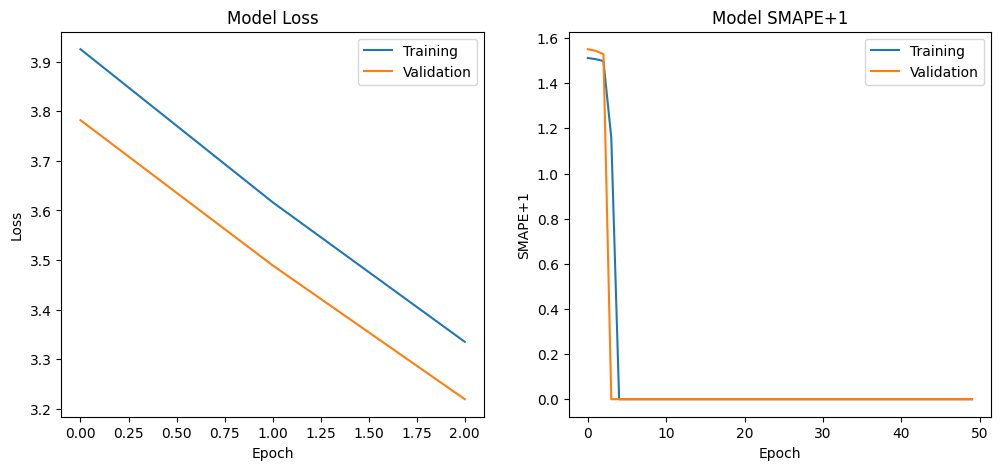

Final training loss: nan
Final validation loss: nan


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(['Training', 'Validation'])

# Plot training and validation SMAPE+1
axs[1].plot(history.history['smape_loss_plus_one'])
axs[1].plot(history.history['val_smape_loss_plus_one'])
axs[1].set_title('Model SMAPE+1')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('SMAPE+1')
axs[1].legend(['Training', 'Validation'])

plt.show()

# Print the final training and validation loss
print('Final training loss:', history.history['loss'][-1])
print('Final validation loss:', history.history['val_loss'][-1])

In [ ]:
X_features = X.columns

In [ ]:
def prepare_features(clinical, test_proteins, test_peptides):
    """Format features"""
    # X_submission = proteins.pivot(index='visit_id',columns='UniProt', values='NPX')
    X_submission = prepare_dataset(test_proteins, test_peptides)
    missing_visits = np.setdiff1d(np.array(clinical.visit_id.unique()), np.array(X_submission.index)).tolist()
    missing_proteins = np.setdiff1d(np.array(features), np.array(X_submission.columns)).tolist()
    for mv in missing_visits:
        X_submission.loc[mv] = np.NaN
    
    for mp in missing_proteins:
        X_submission.loc[:,mp] = np.NaN
    # print(X_submission.columns)
    # X_submission = X_submission[features]    
    # X_submission['visit_month'] = X_submission.reset_index().visit_id.str.split("_").apply(lambda x: int(x[1])).values    
    X_submission.visit_month = X_submission.visit_month.astype('float')
    
    return X_submission

def get_predictions(features, model):
    """Make predictions from prepared features"""
    X_submission_trans = preprocessor.transform(features)
    # Predict and format ratings
    pred_submission = np.around(np.abs(model.predict(X_submission_trans)),0)
    pred_submission = pd.DataFrame(pred_submission, index= features.index, columns = y.columns)
    
    return pred_submission

def format_predictions(predictions, sample_submission):
    """Format predictions for submission"""
    pred_submission = pd.DataFrame(predictions.stack())

    # Map predictions to sample_submission
    pred_submission.index = pred_submission.index.map('_'.join)
    pred_submission.columns = ['rating']
    sample_submission.rating = sample_submission.prediction_id.map(pred_submission.rating)
    
    return sample_submission.fillna(0)

In [ ]:
# Prepare test features
test_features = prepare_features(test_clinical, test_proteins, test_peptides)[X_features]

# Make predictions for test features
test_predictions = get_predictions(test_features, model)

# Format predictions for submission
test_submission = format_predictions(test_predictions, submission)

# Print the first few rows of the submission
print(test_submission)



Index(['QNC(UniMod_4)ELFEQLGEYK', 'SIDVAC(UniMod_4)HPGYALPK',
       'NVVYTC(UniMod_4)NEGYSLIGNPVAR', 'LVGGPMDASVEEEGVRR', 'ADLSGITGAR',
       'P43652', 'SPVDIC(UniMod_4)TAKPR', 'AESPEVC(UniMod_4)FNEESPK',
       'LAARLEALKENGGAR', 'LPPTSAHGNVAEGETKPDPDVTER',
       ...
       'YNSQNQSNNQFVLYR', 'IHWESASLLR',
       'HYTNPSQDVTVPC(UniMod_4)PVPPPPPC(UniMod_4)C(UniMod_4)HPR',
       'QC(UniMod_4)VPTEPC(UniMod_4)EDAEDDC(UniMod_4)GNDFQC(UniMod_4)STGR',
       'SIVVSPILIPENQR', 'KPVDEYKDC(UniMod_4)HLAQVPSHTVVAR',
       'AFPALTSLDLSDNPGLGER', 'C(UniMod_4)VDVDEC(UniMod_4)APPAEPC(UniMod_4)GK',
       'ALDFAVGEYNK', 'visit_month'],
      dtype='object', length=1079)
1/1 [==============================] - 1s 703ms/step
                     prediction_id  rating  group_key
0     3342_0_updrs_1_plus_0_months     0.0          0
1     3342_0_updrs_1_plus_6_months     0.0          0
2    3342_0_updrs_1_plus_12_months     0.0          0
3    3342_0_updrs_1_plus_24_months     0.0          0
4     334

In [ ]:
# test_features = prepare_features(test_clinical, test_proteins)
# test_predictions = get_predictions(test_features,model)
# test_submission = format_predictions(test_predictions, submission)
# test_submission

1/1 [==============================] - 0s 125ms/step


,prediction_id,rating,group_key
0,3342_0_updrs_1_plus_0_months,6.0,0
1,3342_0_updrs_1_plus_6_months,6.0,0
2,3342_0_updrs_1_plus_12_months,7.0,0
3,3342_0_updrs_1_plus_24_months,7.0,0
4,3342_0_updrs_2_plus_0_months,6.0,0
...,...,...,...
59,50423_6_updrs_3_plus_24_months,20.0,6
60,50423_6_updrs_4_plus_0_months,0.0,6
61,50423_6_updrs_4_plus_6_months,0.0,6
62,50423_6_updrs_4_plus_12_months,0.0,6


### Submission for Sequential Model with GRU

In [ ]:
import sys
sys.path.append('/kaggle/input/amp-parkinsons-disease-progression-prediction')

import amp_pd_peptide_310
env = amp_pd_peptide_310.make_env()   # environment provided by competition
iter_test = env.iter_test()

In [ ]:
for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    sub_features = prepare_features(test, test_proteins)
    sub_predictions = get_predictions(sub_features,model)
    submission = format_predictions(sub_predictions, sample_submission)

    env.predict(submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1/1 [==============================] - 0s 125ms/step


In [ ]:
pd.read_csv('/kaggle/working/submission.csv')

,prediction_id,rating
0,3342_0_updrs_1_plus_0_months,6.0
1,3342_0_updrs_1_plus_6_months,6.0
2,3342_0_updrs_1_plus_12_months,7.0
3,3342_0_updrs_1_plus_24_months,7.0
4,3342_0_updrs_2_plus_0_months,6.0
...,...,...
59,50423_6_updrs_3_plus_24_months,20.0
60,50423_6_updrs_4_plus_0_months,0.0
61,50423_6_updrs_4_plus_6_months,0.0
62,50423_6_updrs_4_plus_12_months,0.0


References: https://www.kaggle.com/code/umbertofasci/amp-pdpp-eda-tf-model/notebook#sMAPE-Function